# Notes
* RandomForest is awesome!
* I think what we could then do is evaluate chained multi output regression with like a linear model in addition to random forest and neural network. 
* I really like how random forest returns feature importances (it's not a black box) 


### To do next
* Read about random forests and decision trees
* See how it works when I use non default parameters 
* Read this: [sklean plot importances](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)
* Read this: [randomforest documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* Read three machinelearningmastery articles about randomforests: [first](https://machinelearningmastery.com/random-forest-ensemble-in-python/), [second](https://machinelearningmastery.com/implement-random-forest-scratch-python/), and [third](https://machinelearningmastery.com/bagging-and-random-forest-ensemble-algorithms-for-machine-learning/). 
* **Big Picture:** read about random forest, test third model, re process all spectral / qpo data. 

### Other notes
* I will need to get citations for all of the hyperparameter tuning and model decsisions I make ... I should probably check out a lot of the machine learning mastery articles because I remember he often provides a lot of citations at the begining of them. 
* I should probably write an appendix to this paper to include a lot more evaluation things etc. 
* I should definately make a "see the forest for the trees" sort of comment
*Do I need to switch to k-fold cross validation ? 

### Code to make .dot file 
```python
from sklearn.tree import export_graphviz
export_graphviz(tree_in_forest,
                feature_names=,
                class_names=,
                filled=True,
                rounded=True)
os.system('dot -Tpng tree.dot -o tree.png')
```

Then paste the ```DOT``` file text contents in this website: ```https://dreampuf.github.io/GraphvizOnline```




In [144]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale as normalize
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, mean_squared_error, median_absolute_error
from sklearn.ensemble import RandomForestRegressor

plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family']='serif'
plt.rcParams['figure.dpi']=150

data_df = pd.read_csv('https://raw.githubusercontent.com/thissop/MAXI-J1535/main/data/processed/fixed_merged.csv?token=AQN5JTYUIYYWNOZEPNSU42LBZT3E2')

## Split Data

In [138]:
no_qpo_idx = np.where(data_df['first_par1s']==0)[0]
has_qpo_idx = np.where(data_df['first_par1s']!=0)[0]

has_qpo_df = data_df.iloc[has_qpo_idx, :].sample(frac=1)
no_qpo_df = data_df.iloc[no_qpo_idx, :].sample(frac=1)

print(len(has_qpo_df.index))

57


In [139]:
# QPO DATA

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(has_qpo_df['num_qpos']).reshape(len(has_qpo_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])


def split_data(x_vals, y_vals, num_qpos): 
    # Train test split
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = train_test_split(x_vals, y_vals, num_qpos, test_size=0.1)
    return X_train, X_test, y_train, y_test, qpo_train, qpo_test

In [140]:
def knn_predict(k, xtrain, ytrain, xtest, ytest): 
    knn = KNeighborsClassifier(k)
    knn.fit(xtrain, ytrain)
    predictions = knn.predict(xtest)
    acc = accuracy_score(predictions, ytest.flatten())

    return acc, predictions

def cullBuffers(x, qpo_classes):
    new_x = np.array([], dtype=np.float64).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

In [141]:
X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 

knn_acc, knn_predictions = knn_predict(7, X_train, qpo_train, X_test, qpo_test)

knn_predictions = knn_predictions.flatten().astype(int)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


## Test Different Models

### RandomForest

In [142]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)
rf_predictions = cullBuffers(regr.predict(X_test), knn_predictions).flatten()

mse = mean_squared_error(y_test.flatten(), rf_predictions)
mae = median_absolute_error(y_test.flatten(), rf_predictions)

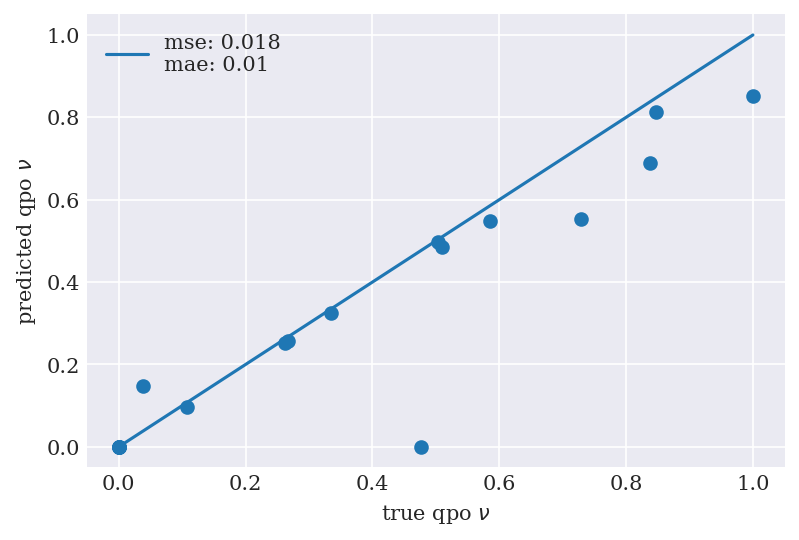

In [145]:
fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(y_test.flatten(), rf_predictions)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()

## KNN-RandomForest Ensemble
*sanity check from scratch* 

In [146]:
# Split data into qpo present and qpo absent 

no_qpo_idx = np.where(data_df['first_par1s']==0)[0]
has_qpo_idx = np.where(data_df['first_par1s']!=0)[0]

has_qpo_df = data_df.iloc[has_qpo_idx, :].sample(frac=1)
no_qpo_df = data_df.iloc[no_qpo_idx, :].sample(frac=1)

print(len(has_qpo_df.index))

57


In [147]:
# prepare data for analysis

# QPO DATA

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities) = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness, tins, disk_norms, gammas, nthcomp_norms, intensities): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals = np.vstack([x_vals, new_arr])

# num QPOS
num_qpos = np.array(has_qpo_df['num_qpos']).reshape(len(has_qpo_df), 1).astype(int)

# Y 
y_vals = np.array([], dtype=np.float32).reshape(0, 3)

freq1s, freq2s, freq3s = (normalize(np.array(has_qpo_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s, freq2s, freq3s): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals = np.vstack([y_vals, new_arr])

# NO QPO DATA

# X

arr_names =  ['hardness', 'tins', 'disk_norm', 'gammas', 'nthcomp_norms', 'intensities']
(hardness_no_qpo, tins_no_qpo, disk_norms_no_qpo, gammas_no_qpo, nthcomp_norms_no_qpo, intensities_no_qpo) = (normalize(np.array(no_qpo_df[arr_name])) for arr_name in arr_names)

## Stack x values
x_vals_no_qpo = np.array([], dtype=np.int64).reshape(0,6) # why are they type int

for a, b, c, d, e, f in zip(hardness_no_qpo, tins_no_qpo, disk_norms_no_qpo, gammas_no_qpo, nthcomp_norms_no_qpo, intensities_no_qpo): 
    new_arr = np.array([float(a), float(b), float(c), float(d), float(e), float(f)])
    x_vals_no_qpo = np.vstack([x_vals_no_qpo, new_arr])

# num QPOS
num_qpos_no_qpo = np.array(no_qpo_df['num_qpos']).reshape(len(no_qpo_df), 1).astype(int)

# Y 
y_vals_no_qpo = np.array([], dtype=np.float32).reshape(0, 3)

freq1s_no_qpo, freq2s_no_qpo, freq3s_no_qpo = (normalize(np.array(no_qpo_df[arr_name])) for arr_name in ['first_par1s', 'second_par1s', 'third_par1s'])

for freq1, freq2, freq3 in zip(freq1s_no_qpo, freq2s_no_qpo, freq3s_no_qpo): 
    new_arr = np.array([float(freq1), float(freq2), float(freq3)])
    y_vals_no_qpo = np.vstack([y_vals_no_qpo, new_arr])

In [148]:
# General functions

def split_data(x_vals, y_vals, num_qpos): 
    # Train test split
    X_train, X_test, y_train, y_test, qpo_train, qpo_test = train_test_split(x_vals, y_vals, num_qpos, test_size=0.1)
    return X_train, X_test, y_train, y_test, qpo_train, qpo_test

def knn_predict(k, xtrain, ytrain, xtest, ytest): 
    knn = KNeighborsClassifier(k)
    knn.fit(xtrain, ytrain)
    predictions = knn.predict(xtest)
    acc = accuracy_score(predictions, ytest.flatten())

    return acc, predictions

def cullBuffers(x, qpo_classes):
    new_x = np.array([], dtype=np.float64).reshape(0,3)
    for x_row, qpo_class in zip(x, qpo_classes): 
        if qpo_class == 0: 
            new_x = np.vstack([new_x, np.zeros(3)])

        elif qpo_class == 1:
            new_x = np.vstack([new_x, [x_row[0], 0, 0]])

        elif qpo_class == 2: 
            new_x = np.vstack([new_x, [x_row[0], x_row[1], 0]])

        elif qpo_class == 3: 
            new_x = np.vstack([new_x, x_row[0:3]])

    return new_x

def drop_no_qpo(X_test, y_test, knn_qpo_predictions): 
    non_zero_indices = np.where(knn_qpo_predictions!=0)
    return X_test[non_zero_indices], y_test[non_zero_indices]

In [149]:
# train test splitting and combining

X_train, X_test, y_train, y_test, qpo_train, qpo_test = split_data(x_vals, y_vals, num_qpos) 
X_train_no_qpo, X_test_no_qpo, y_train_no_qpo, y_test_no_qpo, qpo_train_no_qpo, qpo_test_no_qpo = split_data(x_vals_no_qpo, y_vals_no_qpo, num_qpos_no_qpo) 

X_train_combined = np.concatenate((X_train, X_train_no_qpo))
X_test_combined = np.concatenate((X_test, X_test_no_qpo))
qpo_train_combined = np.concatenate((qpo_train, qpo_train_no_qpo))
qpo_test_combined = np.concatenate((qpo_test, qpo_test_no_qpo))

y_test_combined = np.concatenate((y_test, y_test_no_qpo))

In [150]:
knn_acc, knn_predictions = knn_predict(7, X_train_combined, qpo_train_combined, X_test_combined, qpo_test_combined)

knn_predictions = knn_predictions.flatten().astype(int)
knn_predictions

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


array([2, 2, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [151]:
regr = RandomForestRegressor()
regr.fit(X_train, y_train)

x_test_no_qpo_predicted, y_test_no_qpo_predicted = drop_no_qpo(X_test_combined, y_test_combined, knn_predictions)

rf_predictions = cullBuffers(regr.predict(x_test_no_qpo_predicted), knn_predictions).flatten()

mse = mean_squared_error(y_test_no_qpo_predicted.flatten(), rf_predictions)
mae = median_absolute_error(y_test_no_qpo_predicted.flatten(), rf_predictions)

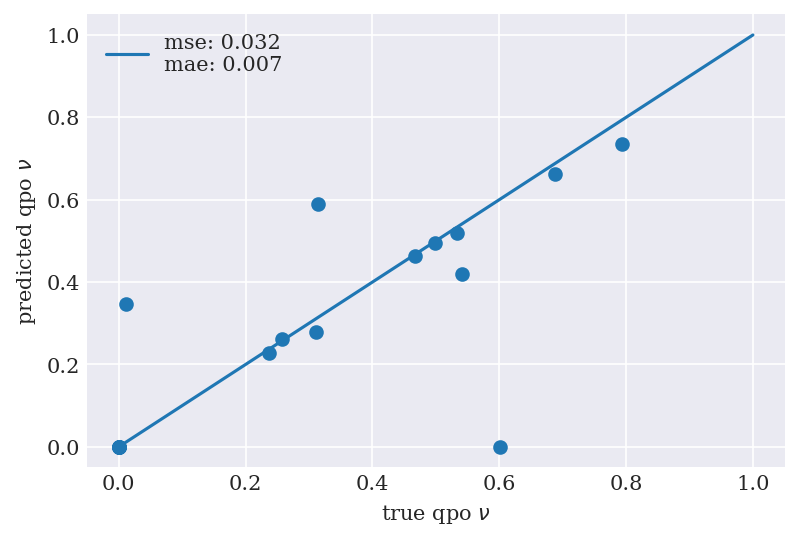

In [152]:
fig, ax = plt.subplots()

line_label = 'mse: '+str(round(mse, 3))+'\n'+'mae: '+str(round(mae, 3))
ax.plot([0,1], [0,1], label=line_label)
ax.scatter(y_test_no_qpo_predicted.flatten(), rf_predictions)

ax.set(xlabel='true qpo '+r'$\nu$', ylabel='predicted qpo '+r'$\nu$')
ax.legend()
plt.show()

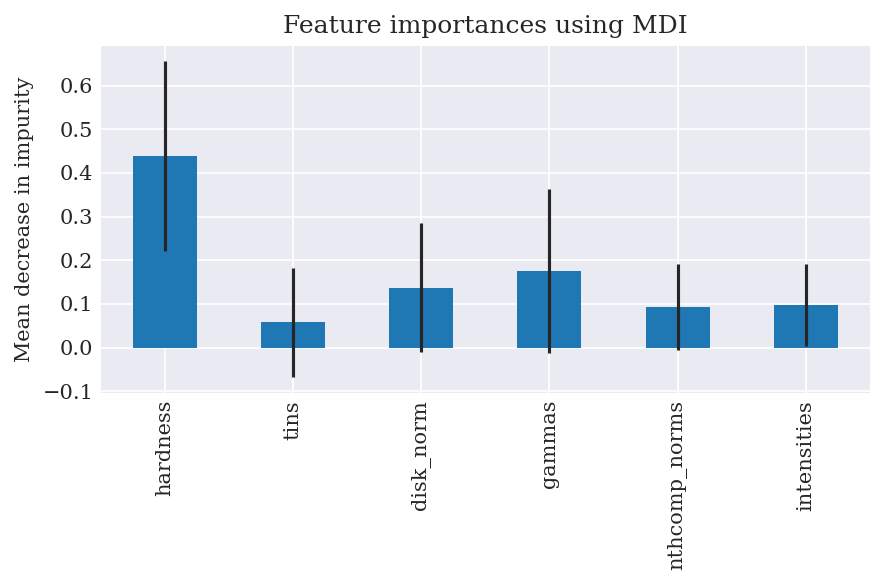

In [156]:
importances = regr.feature_importances_
std = np.std([tree.feature_importances_ for tree in regr.estimators_], axis=0)

forest_importances = pd.Series(importances, index=arr_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()